### First tutorial Netket
https://netket.readthedocs.io/en/latest/tutorials/gs-ising.html

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
### Defining Hilbert space
import netket as nk

N = 20
hi = nk.hilbert.Spin(s = 1/2, N=N)

∣NK⟩ Tip: You must cite NetKet according to our policy. Use nk.cite() to find out how.

In [3]:
### Getting random states
import jax
state = hi.random_state(jax.random.key(0), 1)

In [4]:
### Specifying the Hamiltonian
from netket.operator.spin import sigmax, sigmaz

# Not completely clear on the spin specifics wrt Hamiltonian, don't think its groundbreaking though
Gamma, V = -1, -1

# Single sites
H = sum([Gamma * sigmax(hi, i) for i in range(N)])
# Interaction terms
H += sum([V * sigmaz(hi, i) @ sigmaz(hi, (i + 1) % N) for i in range(N)])

In [5]:
### Mean field Ansatz - Variational approximiation of the ground state - 1 param Gaussian

import jax.numpy as jnp
from flax import nnx

class MF(nnx.Module):
    # RNG used to initialize parameters of the model
    def __init__(self, *, rngs: nnx.Rngs):
        key = rngs.params()
        self.log_phi_local = nnx.Param(jax.random.normal(key, (1,)))

    # x.shape = (n_samples, L), returns n_samples amps
    def __call__(self, x: jax.Array):
        p = nnx.log_sigmoid(self.log_phi_local * x)
        return 0.5 * jnp.sum(p, axis=-1)


In [6]:
mf_model = MF(rngs=nnx.Rngs(0))  # Learn more about the model at https://flax.readthedocs.io/en/latest/nnx_basics.html

In [7]:
### Sampler
sampler = nk.sampler.MetropolisLocal(hi)
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=512)

In [8]:
def rel(x):
    return jnp.mean(x ** 2) + jnp.mean(x**3)

In [9]:
# KE is Hessian, PE can be added as is, what a pain, why does he return Stats!!!

s = jax.random.normal(jax.random.key(0), 10)
rel(s)

Array(1.29511519, dtype=float64)

In [14]:
jax.jacfwd(jax.grad(rel))(s)

Array([[ 0.07649472,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.27085947,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.289652  ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.31270641,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.24852073,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02326648,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.91409823,  0.        

In [12]:
jax.jacfwd(rel)(s)

Array([-0.02845713,  0.02780404,  1.35266858,  0.04815441,  0.01813546,
       -0.03288223,  0.66297965,  0.10213204,  0.0191238 ,  0.05365633],      dtype=float64)

In [17]:
x = vstate.samples

In [28]:
x_in = x[0][0]

In [29]:
x_in.shape

(20,)

In [30]:
x_in

Array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1], dtype=int8)

In [31]:
jax.grad(mf_model)(jnp.astype(x_in, float))

Array([0.12444429, 0.12444429, 0.12444429, 0.12444429, 0.12444429,
       0.12444429, 0.12444429, 0.12444429, 0.12444429, 0.12444429,
       0.12444429, 0.12444429, 0.12444429, 0.12444429, 0.12444429,
       0.12444429, 0.12444429, 0.12444429, 0.81557065, 0.81557065],      dtype=float64)

In [32]:
t = jax.jacfwd(jax.grad(mf_model))(jnp.astype(x_in, float))

In [36]:
t = jax.hessian(mf_model)(jnp.astype(x_in, float))

In [38]:
jnp.diag(t)[0]

Array(-0.20298623, dtype=float64)

In [8]:

def get_flat_arr(dict_arr):
    flat_arr, _ = jax.flatten_util.ravel_pytree(dict_arr)
    return flat_arr

for i in range(10):
    vstate.sample()
    E_1, E_grad = vstate.expect_and_grad(H)
    E_2, F = vstate.expect_and_forces(H)
    E_grad = get_flat_arr(E_grad)
    F = get_flat_arr(F)
    print(vstate.samples[0][0])
    print(E_1)
    print(E_2)
    print(E_1)
    print(E_grad)
    print(2 * F)

[ 1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1  1]
-24.464 ± 0.100 [σ²=5.1e+00, R̂=1.031]
-24.464 ± 0.100 [σ²=5.1e+00, R̂=1.031]
-24.464 ± 0.100 [σ²=5.1e+00, R̂=1.031]
[-1.80525527]
[-1.80525527]
[-1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1]
-24.47 ± 0.10 [σ²=5.5e+00, R̂=1.024]
-24.47 ± 0.10 [σ²=5.5e+00, R̂=1.024]
-24.47 ± 0.10 [σ²=5.5e+00, R̂=1.024]
[-2.17811827]
[-2.17811827]
[ 1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1]
-24.250 ± 0.099 [σ²=5.0e+00, R̂=1.020]
-24.250 ± 0.099 [σ²=5.0e+00, R̂=1.020]
-24.250 ± 0.099 [σ²=5.0e+00, R̂=1.020]
[-1.6886849]
[-1.6886849]
[-1  1  1 -1  1  1  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1]
-24.22 ± 0.10 [σ²=5.5e+00, R̂=1.020]
-24.22 ± 0.10 [σ²=5.5e+00, R̂=1.020]
-24.22 ± 0.10 [σ²=5.5e+00, R̂=1.020]
[-1.96274707]
[-1.96274707]
[ 1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1]
-24.35 ± 0.10 [σ²=5.5e+00, R̂=1.009]
-24.35 ± 0.10 [σ²=5.5e+00, R̂=1.009]
-24.35 ± 0.10 [σ²=5.5e+00, R̂=1.009]
[-1.97883571]

In [17]:
sampler.sample(mf_model, )

TypeError: Sampler.sample() missing 2 required positional arguments: 'machine' and 'parameters'

In [28]:
### Expecation values and metrics
vstate.expect(H)

-24.37 ± 0.10 [σ²=5.55, R̂=1.0217]

In [29]:
vstate.expect_and_grad(H)

(-24.37 ± 0.10 [σ²=5.55, R̂=1.0217],
 {'log_phi_local': Array([-1.47887993], dtype=float64)})

In [30]:
### Optimization loop

from tqdm import tqdm

energy_history = []
n_steps = 200
lr = 0.05

for i in tqdm(range(n_steps)):
    E, E_grad = vstate.expect_and_grad(H)
    energy_history.append(E.mean.real)

    new_pars = jax.tree_util.tree_map(
        lambda x, y: x - lr * y, vstate.parameters, E_grad
    )

    vstate.parameters = new_pars

100%|██████████| 200/200 [00:03<00:00, 64.11it/s]


Text(0.5, 1.0, 'Mean-field ansatz N=20')

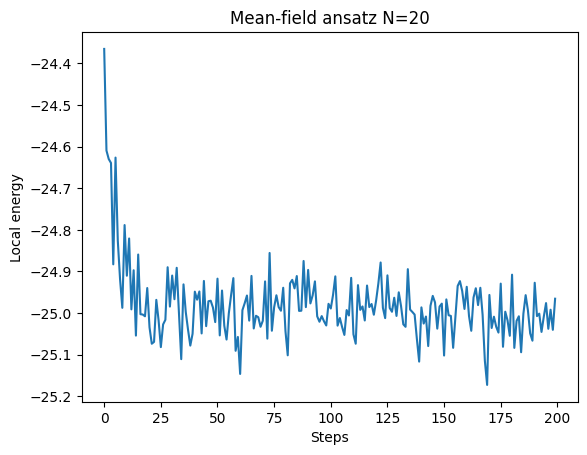

In [31]:

import matplotlib.pyplot as plt

plt.plot(energy_history)
plt.xlabel("Steps")
plt.ylabel("Local energy")
plt.title("Mean-field ansatz N=20")

In [34]:
### Using Netket's optimization driver
vstate.init_parameters()
optimizer = nk.optimizer.Sgd(learning_rate=lr)
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

gs.run(n_iter=1000)  # How do we inspect changes here
mf_energy = vstate.expect(H)
error = abs((mf_energy.mean - eig_vals[0]) / eig_vals[0])
print("Optimized energy and relative error: ", mf_energy, error)

100%|██████████| 1000/1000 [00:18<00:00, 52.72it/s, Energy=-24.960 ± 0.047 [σ²=1.148, R̂=1.0263]]


Optimized energy and relative error:  -25.053 ± 0.053 [σ²=1.434, R̂=1.0114] 0.01717349613673736


In [39]:
### Jastrow Ansatz
class Jastrow(nnx.Module):

    def __init__(self, *, rngs: nnx.Rngs):
        self.j1 = nnx.Param(0.01 * jax.random.normal(rngs.params(), (1,)), dtype=float)
        self.j2 = nnx.Param(0.01 * jax.random.normal(rngs.params(), (1,)), dtype=float)

    def __call__(self, x: jax.Array):
        # NN correlation
        corr1 = x * jnp.roll(x, -1, axis=-1)  # don't understand jnp.roll
        corr2 = x * jnp.roll(x, -2, axis=-1)

        return jnp.sum(self.j1 * corr1 + self.j2 * corr2, axis=-1)

In [ ]:
jastrow_model = Jastrow(rngs=nnx.Rngs(1))
vstate = nk.vqs.MCState(sampler, jastrow_model, n_samples=512)

In [52]:
### Optimizing and logging - using SR
vstate.init_parameters()
optimizer = nk.optimizer.Sgd(learning_rate=0.01)

gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.01),
)

log = nk.logging.RuntimeLog()

gs.run(n_iter=300, out=log)
jas_energy = vstate.expect(H)
error = abs((jas_energy.mean - eig_vals[0])/ eig_vals[0])

100%|██████████| 300/300 [00:04<00:00, 66.57it/s, Energy=-25.312 ± 0.028 [σ²=0.415, R̂=1.0403]]


Text(0.5, 1.0, 'Jastrow Ansatz')

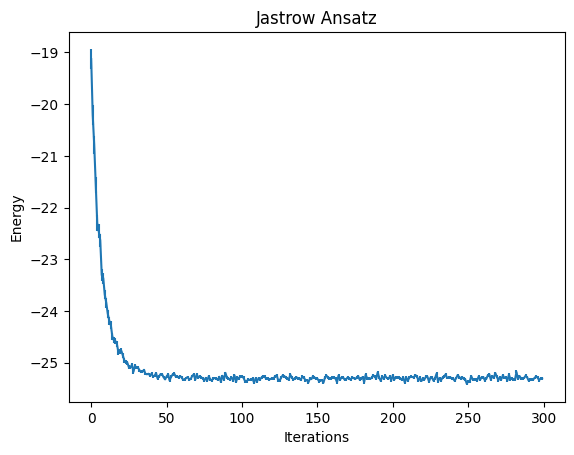

In [53]:
data_jastrow = log.data
plt.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean,
    yerr=data_jastrow["Energy"].Sigma,
)

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Jastrow Ansatz")

In [56]:
### Neural Network Quantum State
class FFN(nnx.Module):

    def __init__(self, N: int, alpha:int = 1, *, rngs: nnx.Rngs):
        self.alpha = alpha
        self.linear = nnx.Linear(in_features=N, out_features = alpha * N, rngs=rngs)

    def __call__(self, x: jax.Array):
        y = self.linear(x)
        y = nnx.relu(y) # max(0, X)
        return jnp.sum(y, axis=-1)

In [63]:
model = FFN(N=N, alpha=2, rngs=nnx.Rngs(2))
# Basically something that implements __call__ and is a subclass of nnx.Module is compatible with their model interface
vstate = nk.vqs.MCState(sampler, model, n_samples=512)

In [64]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)

# Wow the preconditioner has a large effect, and requires a large diagonal shift. It's few parameters, I assume that's why

vstate.init_parameters()
log = nk.logging.RuntimeLog()
gs.run(n_iter=300, out=log)
ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean - eig_vals[0])/ eig_vals[0])
print(error)

100%|██████████| 300/300 [00:08<00:00, 34.26it/s, Energy=-25.4797 ± 0.0073 [σ²=0.0276, R̂=1.0216]]


0.000766624493060426


Text(0, 0.5, 'Energy')

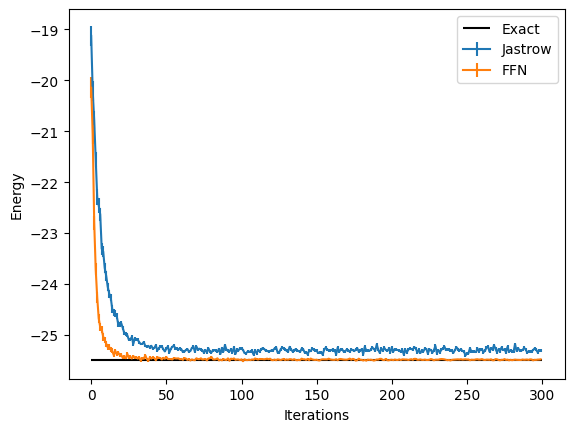

In [65]:
data_FFN = log.data

plt.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean,
    yerr=data_jastrow["Energy"].Sigma,
    label="Jastrow",
)
plt.errorbar(
    data_FFN["Energy"].iters,
    data_FFN["Energy"].Mean,
    yerr=data_FFN["Energy"].Sigma,
    label="FFN",
)
plt.hlines([E_gs], xmin=0, xmax=300, color="black", label="Exact")
plt.legend()

plt.xlabel("Iterations")
plt.ylabel("Energy")

In [68]:
### Dynamics
# Dk RBMs and not super familiar with magnetization and Ising model

import netket.experimental as nkx

L = 20
chain = nk.graph.Chain(L)
hi = nk.hilbert.Spin(s=1/2) ** L

rbm = nk.models.RBM(alpha=1, param_dtype=complex)
sampler = nk.sampler.MetropolisLocal(hi)
vstate = nk.vqs.MCState(sampler, rbm, n_samples=1028)

ha0 = nk.operator.Ising(hi, chain, h=0.5)
# Observable = transverse magnetization
obs = {"sx": sum(nk.operator.spin.sigmax(hi, i) for i in range(L))}

# Start with ground state
optimizer = nk.optimizer.Sgd(0.01)
sr = nk.optimizer.SR()
vmc = nk.VMC(ha0, optimizer, variational_state=vstate, preconditioner=sr)
log = nk.logging.RuntimeLog()
vmc.run(300, out=log)

c:\Users\Parv\anaconda3\envs\jax_cuda\lib\site-packages\netket\vqs\mc\mc_state\state.py:300: UserWarning: n_samples=1028 (1028 per device/MPI rank) does not divide n_chains=16, increased to 1040 (1040 per device/MPI rank)
  self.n_samples = n_samples
  0%|          | 0/300 [00:00<?, ?it/s]c:\Users\Parv\anaconda3\envs\jax_cuda\lib\site-packages\netket\optimizer\qgt\qgt_onthefly.py:139: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probab

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [79]:
hai = nk.operator.Ising(hi, chain, h=1.0)
integrator = nkx.dynamics.Heun(dt=0.05)
qgt = nk.optimizer.qgt.QGTJacobianDense(holomorphic=True)
te = nkx.TDVP(hai, vstate, integrator, qgt=qgt)
log = nk.logging.RuntimeLog()
te.run(T=3.0, out=log, obs=obs)

100%|██████████| 3.00/3.00 [00:47<00:00, 15.7s/it, n=60, Generator=-20.81+0.12j ± 0.17 [σ²=26.34, R̂=1.0192]]


(RuntimeLog():
  keys = ['sx', 'acceptance', 't', 'Generator'],)

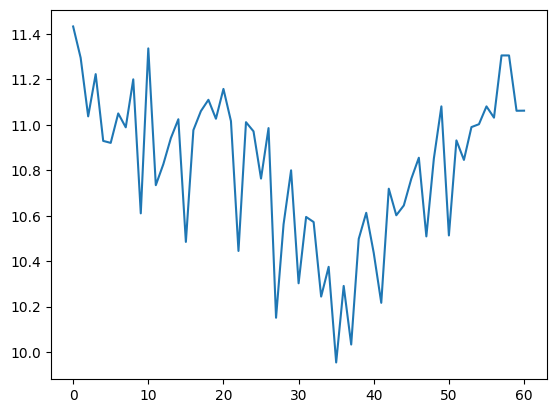

In [80]:
# The exact Hamiltonian remains conserved due to unitary dynamics, but the expectation value of the total magnetization along x axis increases (similar to applying E on top, just on a restricted basis)
plt.plot(log.data['sx'])

In [82]:
### Do the ground state in a continuum (https://netket.readthedocs.io/en/latest/tutorials/gs-continuous-space.html) and then do dyanmics for it. From there start working towards hydrogen - one step at a time